# LIBRARY

In [1]:
##대통합 과정


#Ignorability Assumption Test coding #

import pandas as pd
import numpy as np
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
import rpy2.robjects.packages as rpackages
from rpy2.robjects import numpy2ri
from rpy2.robjects.vectors import StrVector

required_packages = ['base', 'forecast', 'CondIndTests','devtools'] # list of required R packages 
if all(rpackages.isinstalled(x) for x in required_packages):
    check_packages = True # True if packages are already installed 
else:
   check_packages = False # False if packages are not installed 
if check_packages == False: # Not installed? Then install.
    utils = rpackages.importr('utils')
    utils.chooseCRANmirror(ind=1)
    packages_to_install = [x for x in required_packages if not rpackages.isinstalled(x)]
    if len(packages_to_install) > 0:
        utils.install_packages(StrVector(packages_to_install))
    check_packages = True 

r = ro.r
base = importr('base')
forecast = importr('forecast')
graphics = importr('graphics')
grdevices = importr('grDevices')
condindtests = importr('CondIndTests')
devtools = importr('devtools')

required_packages = ['RCIT'] # list of required R packages 
if all(rpackages.isinstalled(x) for x in required_packages):
    check_packages = True # True if packages are already installed 
else:
   check_packages = False # False if packages are not installed 
if check_packages == False: # Not installed? Then install.
    utils = rpackages.importr('utils')
    utils.chooseCRANmirror(ind=1)
    packages_to_install = [x for x in required_packages if not rpackages.isinstalled(x)]
    if len(packages_to_install) > 0:
        r.install_github("ericstrobl/RCIT")
    check_packages = True 

RCIT = importr('RCIT')


def IgnorTest(cause=None, effect=None, explorer=None, covariate=None, level=0.05, dtype="continuous"): #inputs are arrays, dtypes are continuous/binary/mixed
    tmp_cause=pd.DataFrame({'A': cause})
    tmp_effect=pd.DataFrame({'Y': effect})
    tmp_explorer=pd.DataFrame({'V': explorer})
    tmp_covariate = pd.DataFrame(covariate)
    dim_covariate = tmp_covariate.shape[1]
    
    if dtype=="continuous":
        if dim_covariate==0:
            tmp_conditioning=tmp_cause
        else:
            tmp_conditioning=pd.concat([tmp_cause,tmp_covariate],axis=1)

        with localconverter(ro.default_converter + pandas2ri.converter):
            r_from_pd_conditioning = ro.conversion.py2rpy(tmp_conditioning)
        with localconverter(ro.default_converter + pandas2ri.converter):
            r_from_pd_effect = ro.conversion.py2rpy(tmp_effect)
        with localconverter(ro.default_converter + pandas2ri.converter):
            r_from_pd_explorer = ro.conversion.py2rpy(tmp_explorer)
            
        sample_size = r.unlist(r.dim(r_from_pd_conditioning))[0]
        dim = r.unlist(r.dim(r_from_pd_conditioning))[1]
            
        r_from_pd_explorer=r.unlist(r_from_pd_explorer)    
        r_from_pd_effect=r.unlist(r_from_pd_effect)   
        r_from_pd_conditioning=r.unlist(r_from_pd_conditioning)   
        r_from_pd_conditioning=r.matrix(r_from_pd_conditioning,sample_size,dim)
        
        #test=r.CondIndTest(r_from_pd_explorer,r_from_pd_effect,r_from_pd_conditioning, method = "KCI")
        #pvalue=r.unlist(test)[3]
        
        test=r.RCoT(r_from_pd_explorer,r_from_pd_effect,r_from_pd_conditioning,seed=2)
        pvalue=r.unlist(test)[0]
        print(pvalue)
            
    elif dtype=="mixed":
        dat_mixed=pd.concat([tmp_effect,tmp_explorer,tmp_cause,tmp_covariate],axis=1)
        dat_mixed.columns = ['col1','col2','col3','col4']
        
        mod_restriced = smf.ols('col1 ~ col3*col4 ', data = dat_mixed).fit()
        mod_unrestriced = smf.ols('col1 ~ col2*col3*col4', data = dat_mixed).fit()
        anovaResults = anova_lm(mod_restriced, mod_unrestriced)
        pvalue=anovaResults.iloc[1,5]
        print(pvalue)

    else:
        raise ValueError("dtype is not valid.")
        
    if(pvalue<=level):
        print("The Ignorability Assumption is not satisfied.")
    else:
        print("The Ignorability Assumption is satisfied.")

    return pvalue



# EDA

In [2]:
df=pd.read_csv("C:\\Users\\minsoo\\Desktop\\forestfires.csv")

In [3]:
df.tail(30)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
487,5,4,aug,tue,95.1,141.3,605.8,17.7,26.4,34,3.6,0.0,16.40
488,4,4,aug,tue,95.1,141.3,605.8,17.7,19.4,71,7.6,0.0,46.70
489,4,4,aug,wed,95.1,141.3,605.8,17.7,20.6,58,1.3,0.0,0.00
490,4,4,aug,wed,95.1,141.3,605.8,17.7,28.7,33,4.0,0.0,0.00
491,4,4,aug,thu,95.8,152.0,624.1,13.8,32.4,21,4.5,0.0,0.00
492,1,3,aug,fri,95.9,158.0,633.6,11.3,32.4,27,2.2,0.0,0.00
493,1,3,aug,fri,95.9,158.0,633.6,11.3,27.5,29,4.5,0.0,43.32
494,6,6,aug,sat,96.0,164.0,643.0,14.0,30.8,30,4.9,0.0,8.59
495,6,6,aug,mon,96.2,175.5,661.8,16.8,23.9,42,2.2,0.0,0.00
496,4,5,aug,mon,96.2,175.5,661.8,16.8,32.6,26,3.1,0.0,2.77


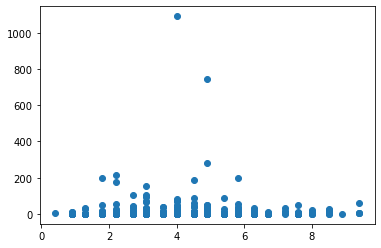

In [4]:
import matplotlib.pyplot as plt

plt.scatter(df['wind'],df['area'])

In [5]:
df.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


(array([ 14.,  45.,  97.,  93.,  92., 113.,  19.,  26.,   5.,  13.]),
 array([0.4, 1.3, 2.2, 3.1, 4. , 4.9, 5.8, 6.7, 7.6, 8.5, 9.4]),
 <BarContainer object of 10 artists>)

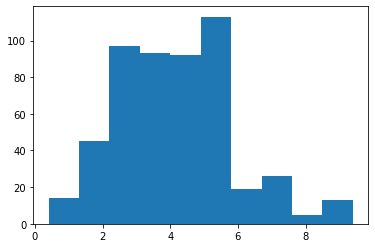

In [6]:
plt.hist(df['wind'])

(array([508.,   6.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   1.]),
 array([   0.   ,  109.084,  218.168,  327.252,  436.336,  545.42 ,
         654.504,  763.588,  872.672,  981.756, 1090.84 ]),
 <BarContainer object of 10 artists>)

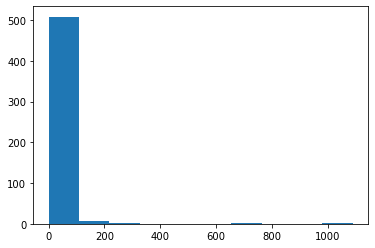

In [7]:
plt.hist(df['area'])

(array([275.,  61.,  59.,  54.,  29.,  21.,   9.,   6.,   1.,   2.]),
 array([0.        , 0.69956196, 1.39912393, 2.09868589, 2.79824785,
        3.49780981, 4.19737178, 4.89693374, 5.5964957 , 6.29605766,
        6.99561963]),
 <BarContainer object of 10 artists>)

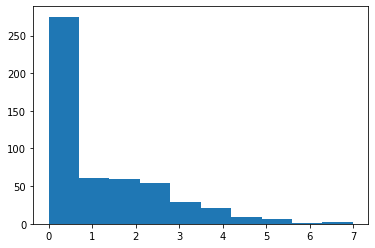

In [8]:
plt.hist(np.log(df['area']+1))

# Modeling

In [9]:
X,y = np.array(df[["wind","temp","RH","rain"]]), np.array(df["area"])

In [10]:
np.random.seed(1)
train_idx=np.random.choice(517,517,replace=False)
#test_idx = np.array(list(set(range(517))-set(train_idx)))

In [11]:
X_train = X[train_idx,]
y_train = y[train_idx,]

#X_test = X[test_idx,]
#y_test = y[test_idx,]

In [12]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics   #Additional scklearn functions

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4


In [13]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='rmse', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    print("n_estimators:", cvresult.shape[0])


In [14]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
xgb_regr = xgb.XGBRegressor(
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    nthread=3,
    scale_pos_weight=1,
    seed=1
    )

In [15]:
train=df.iloc[train_idx,]
train.reset_index(drop=True,inplace=True)

target = 'area'

In [17]:
train['area']=np.log(train['area']+1)

In [18]:
np.log(np.exp(1))

1.0

In [19]:
train

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,2,2,aug,tue,92.1,152.6,658.2,14.3,21.8,56,3.1,0.0,0.418710
1,6,5,aug,sat,90.2,96.9,624.2,8.9,14.7,59,5.8,0.0,0.000000
2,4,6,sep,thu,93.7,80.9,685.2,17.9,17.6,42,3.1,0.0,0.000000
3,3,4,sep,fri,93.3,141.2,713.9,13.9,18.6,49,3.6,0.0,3.607669
4,7,4,sep,wed,90.1,82.9,735.7,6.2,15.4,57,4.5,0.0,3.656098
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,2,5,oct,sun,92.6,46.5,691.8,8.8,15.4,35,0.9,0.0,0.000000
513,2,5,aug,wed,95.5,99.9,513.3,13.2,23.8,32,5.4,0.0,0.570980
514,5,4,mar,fri,91.7,33.3,77.5,9.0,15.6,25,6.3,0.0,0.000000
515,8,6,aug,sun,91.4,142.4,601.4,10.6,19.6,41,5.8,0.0,5.285637


In [20]:
predictors = ["wind","temp","RH","rain"]

In [22]:
# 튜닝 시작
modelfit(xgb_regr,train,predictors)

n_estimators: 21


In [23]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

xgb1_regr = xgb.XGBRegressor(
    learning_rate=0.01,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    nthread=3,
    scale_pos_weight=1,
    seed=1
    )

In [24]:
modelfit(xgb1_regr,train,predictors)

n_estimators: 152


In [25]:
from sklearn.model_selection import GridSearchCV

param_test1={
    'max_depth':range(1,10,1),
    'min_child_weight':range(1,10,1)
}

gsearch1 = GridSearchCV(estimator=XGBRegressor(learning_rate=0.1, n_estimators=21, max_depth=5, min_child_weight=1,
                                              gamma=0, subsample=0.8, colsample_bytree=0.8,
                                              objective='reg:squarederror', nthread=3, scale_pos_weight=1, seed=1),
                       param_grid = param_test1, scoring='neg_root_mean_squared_error', n_jobs=3, cv=5)

In [26]:
gsearch1.fit(train[predictors],train[target])
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 2, 'min_child_weight': 7}, -1.3940714242598347)

In [27]:
param_test3={
    'gamma':[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7]
}

gsearch3 = GridSearchCV(estimator=XGBRegressor(learning_rate=0.1, n_estimators=21, max_depth=2, min_child_weight=7,
                                              gamma=0, subsample=0.8, colsample_bytree=0.8,
                                              objective='reg:squarederror', nthread=3, scale_pos_weight=1, seed=1),
                       param_grid = param_test3, scoring='neg_root_mean_squared_error', n_jobs=3, cv=5)

In [28]:
gsearch3.fit(train[predictors],train[target])
gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.6}, -1.3939461304657885)

In [29]:
xgb2_regr = xgb.XGBRegressor(
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=2,
    min_child_weight=7,
    gamma=0.6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    nthread=3,
    scale_pos_weight=1,
    seed=1
    )

modelfit(xgb2_regr, train, predictors)

n_estimators: 24


In [30]:
param_test4 = {
    'subsample': [0.6,0.7,0.8,0.9],  #[i/10.0 for i in range(6,10)],
    'colsample_bytree': [0.6,0.7,0.8,0.9]  #[1/10.0 for i in range(6,10)]
}

gsearch4 = GridSearchCV(estimator=XGBRegressor(learning_rate=0.1, n_estimators=24, max_depth=2, min_child_weight=7,
                                              gamma=0.6, subsample=0.8, colsample_bytree=0.8,
                                              objective='reg:squarederror', nthread=3, scale_pos_weight=1, seed=1),
                       param_grid = param_test4, scoring='neg_root_mean_squared_error', n_jobs=3, cv=5)

In [31]:
gsearch4.fit(train[predictors],train[target])
gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 0.8, 'subsample': 0.8}, -1.3928540007013213)

In [32]:
param_test5 = {
    'subsample': [0.7,0.75,0.8,0.85,0.9],  #[i/10.0 for i in range(6,10)],
    'colsample_bytree': [0.7,0.75,0.8,0.85,0.9]  #[1/10.0 for i in range(6,10)]
}

gsearch5 = GridSearchCV(estimator=XGBRegressor(learning_rate=0.1, n_estimators=24, max_depth=2, min_child_weight=7,
                                              gamma=0.6, subsample=0.8, colsample_bytree=0.8,
                                              objective='reg:squarederror', nthread=3, scale_pos_weight=1, seed=1),
                       param_grid = param_test5, scoring='neg_root_mean_squared_error', n_jobs=3, cv=5)

In [33]:
gsearch5.fit(train[predictors],train[target])
gsearch5.best_params_, gsearch5.best_score_

({'colsample_bytree': 0.75, 'subsample': 0.8}, -1.3928540007013213)

In [40]:
param_test6 = {
    'reg_alpha': [0,10**-6,10**-5,10**-2,0.1,1,100],  #[i/10.0 for i in range(6,10)],
    'reg_lambda': [0.01,0.1,0.5,1,2,5]  #[1/10.0 for i in range(6,10)]
}

gsearch6 = GridSearchCV(estimator=XGBRegressor(learning_rate=0.1, n_estimators=24, max_depth=2, min_child_weight=7,
                                              gamma=0.6, subsample=0.8, colsample_bytree=0.75,
                                              objective='reg:squarederror', nthread=3, scale_pos_weight=1, seed=1),
                       param_grid = param_test6, scoring='neg_root_mean_squared_error', n_jobs=3, cv=5)

In [41]:
gsearch6.fit(train[predictors],train[target])
gsearch6.best_params_, gsearch6.best_score_

({'reg_alpha': 1e-06, 'reg_lambda': 1}, -1.3928540000475091)

In [42]:
xgb3_regr = xgb.XGBRegressor(
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=2,
    min_child_weight=7,
    gamma=0.6,
    subsample=0.8,
    colsample_bytree=0.75,
    objective='reg:squarederror',
    nthread=3,
    scale_pos_weight=1,
    reg_alpha=10**-6,
    reg_lambda=1,
    seed=1
    )

modelfit(xgb3_regr, train, predictors)

n_estimators: 24


In [43]:
xgb4_regr = xgb.XGBRegressor(
    learning_rate=0.01,
    n_estimators=1000,
    max_depth=2,
    min_child_weight=7,
    gamma=0.6,
    subsample=0.8,
    colsample_bytree=0.75,
    objective='reg:squarederror',
    nthread=3,
    scale_pos_weight=1,
    reg_alpha=10**-6,
    reg_lambda=1,
    seed=1
    )

modelfit(xgb4_regr, train, predictors)

n_estimators: 204


In [44]:
param_test7 = {
    'learning_rate': [0.01,0.1],  #[i/10.0 for i in range(6,10)],
    'n_estimators': [24,204]  #[1/10.0 for i in range(6,10)]
}

gsearch7 = GridSearchCV(estimator=XGBRegressor(learning_rate=0.1, n_estimators=5, max_depth=2, min_child_weight=7,
                                              gamma=0.6, subsample=0.8, colsample_bytree=0.75,
                                              objective='reg:squarederror', nthread=3, scale_pos_weight=1,reg_alpha=10**-6,
                                               reg_lambda=1, seed=1),
                       param_grid = param_test7, scoring='neg_root_mean_squared_error', n_jobs=3, cv=5)

In [45]:
gsearch7.fit(train[predictors],train[target])
gsearch7.best_params_, gsearch7.best_score_

({'learning_rate': 0.1, 'n_estimators': 24}, -1.3928540000475091)

In [51]:
xgbt_regr = gsearch7

In [52]:
import copy

X_1 = copy.deepcopy(X)
X_2 = copy.deepcopy(X)
X_3 = copy.deepcopy(X)
X_4 = copy.deepcopy(X)
X_5 = copy.deepcopy(X)
X_6 = copy.deepcopy(X)
X_7 = copy.deepcopy(X)

X_1[:,0] = 4.017602-3*1.791653 # wind speed change
X_2[:,0] = 4.017602-2*1.791653
X_3[:,0] = 4.017602-1*1.791653
X_4[:,0] = 4.017602
X_5[:,0] = 4.017602+1*1.791653
X_6[:,0] = 4.017602+2*1.791653
X_7[:,0] = 4.017602+3*1.791653

pred1 = np.exp(xgbt_regr.predict(X_1))-1
pred1[pred1<0,]=0

pred2 = np.exp(xgbt_regr.predict(X_2))-1
pred2[pred2<0,]=0

pred3 = np.exp(xgbt_regr.predict(X_3))-1
pred3[pred3<0,]=0

pred4 = np.exp(xgbt_regr.predict(X_4))-1
pred4[pred4<0,]=0

pred5 = np.exp(xgbt_regr.predict(X_5))-1
pred5[pred5<0,]=0

pred6 = np.exp(xgbt_regr.predict(X_6))-1
pred6[pred6<0,]=0

pred7 = np.exp(xgbt_regr.predict(X_7))-1
pred7[pred7<0,]=0

In [53]:
print(np.mean(pred1))
print(np.var(pred1)/517)
print(np.mean(pred1)-1.96*np.sqrt(np.var(pred1)/517))
print(np.mean(pred1)+1.96*np.sqrt(np.var(pred1)/517))

1.6006761
0.00036732915868150425
1.5631110268333783
1.6382410926124225


In [54]:
print(np.mean(pred2))
print(np.var(pred2)/517)
print(np.mean(pred2)-1.96*np.sqrt(np.var(pred2)/517))
print(np.mean(pred2)+1.96*np.sqrt(np.var(pred2)/517))

1.6006761
0.00036732915868150425
1.5631110268333783
1.6382410926124225


In [55]:
print(np.mean(pred3))
print(np.var(pred3)/517)
print(np.mean(pred3)-1.96*np.sqrt(np.var(pred3)/517))
print(np.mean(pred3)+1.96*np.sqrt(np.var(pred3)/517))

1.7444763
0.00039639189925830184
1.7054535157922772
1.7834991209264728


In [56]:
print(np.mean(pred4))
print(np.var(pred4)/517)
print(np.mean(pred4)-1.96*np.sqrt(np.var(pred4)/517))
print(np.mean(pred4)+1.96*np.sqrt(np.var(pred4)/517))

2.0172086
0.0008747237563363819
1.9592401470159653
2.07517700538882


In [57]:
print(np.mean(pred5))
print(np.var(pred5)/517)
print(np.mean(pred5)-1.96*np.sqrt(np.var(pred5)/517))
print(np.mean(pred5)+1.96*np.sqrt(np.var(pred5)/517))

1.8823011
0.001167347514191264
1.8153348154817532
1.949267368813901


In [58]:
print(np.mean(pred6))
print(np.var(pred6)/517)
print(np.mean(pred6)-1.96*np.sqrt(np.var(pred6)/517))
print(np.mean(pred6)+1.96*np.sqrt(np.var(pred6)/517))

2.2863452
0.0016662602959564622
2.206338334046439
2.36635215286152


In [59]:
print(np.mean(pred7))
print(np.var(pred7)/517)
print(np.mean(pred7)-1.96*np.sqrt(np.var(pred7)/517))
print(np.mean(pred7)+1.96*np.sqrt(np.var(pred7)/517))

3.28301
0.0026995206478716556
3.181174459500468
3.3848455524013876
